# Steady-state conduction in a lengthwise-insulated rod with internal heat production

In this notebook we present the code behind [heat transfer in a rod tutorial](https://github.com/camillejr/fluid-dynamics-and-transport-phenomena/blob/master/transport-phenomena-with-Python/example-heat-transfer-in-a-rod.pdf).

The governing ODE for this problem:

$$\frac{d^2 T}{dx^2} = - \frac{Q_p}{\lambda}$$

We start with computing the analytic solution and then compare that with a few numerical solutions.

***

In [1]:
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import math
import numpy as np

# Set some initial parameters:
fontsize_labels = 20
fontsize_axes = 16
fontsize_text = 16
save_plots = True
line_color = '#0e2f44'
FDM_color = '#4fb49d'
FVM_color = '#d57211'
bar_color = '#767676'
help_lines = "#e5e5e5"

# Fonts:
csfont = {'fontname':'Charter', 'fontweight':'regular'}
hfont = {'fontname':'Charter', 'fontweight':'bold'}

***

## Analytic solution

We begin with plotting the analytic solution:

$$T(x) = - \frac{Q_p}{2 \lambda} (x^2 - Lx) + T_0$$

First, let's set the data for this exercise:

In [2]:
T0 = 0       # deg C
L = 200      # m
A = 0.01     # m^2 
Q = 20       # W
Qp = Q/(L*A) # W/m^3
𝝀 = 400      # W/(m*C)

# Discretize the rod:
n_points = 200
x = np.linspace(0, L, n_points)

# Analytic solution:
T = - Qp/(2*𝝀) * (x**2 - L * x) + T0

Plot the analytic solution:

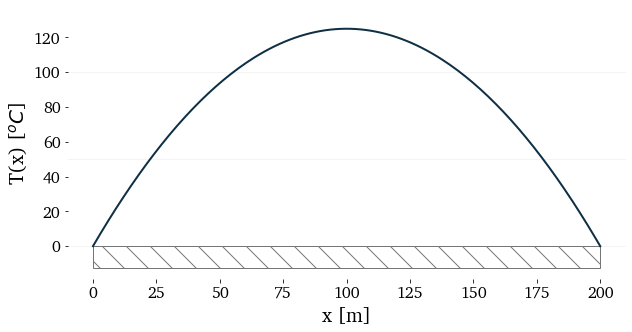

In [3]:
figure = plt.figure(figsize=(10, 5))
ax1 = figure.add_subplot(1,1,1)
plt.plot(x, T, color=line_color, linestyle='-', linewidth=2.0, zorder=1)
plt.xlabel(r'x [m]', fontsize=fontsize_labels, **csfont)
plt.ylabel(r'T(x) [$^o C$]', fontsize=fontsize_labels, **csfont)
plt.xlim(-0.05*L, 1.05*L)
plt.ylim(-0.15*max(T), 1.1*max(T))
ax1.spines["top"].set_visible(False)
ax1.spines["bottom"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax1.spines["left"].set_visible(False)
ax1.margins(x=0)
plt.rcParams['axes.xmargin'] = 0

ax1.add_patch(
    patches.Rectangle(
        (0, -0.1*max(T)),
        L,
        0.1*max(T),
        Fill=False,
        edgecolor=bar_color,
        linewidth=1,
        hatch='\\'
    )
)

for label in (ax1.get_xticklabels()):
    label.set_fontname('Charter')
    label.set_fontweight('regular')
    label.set_fontsize(fontsize_axes)

for label in (ax1.get_yticklabels()):
    label.set_fontname('Charter')
    label.set_fontweight('regular')
    label.set_fontsize(fontsize_axes)

for y in np.arange(min(T), 1.1*max(T), 50):
    plt.plot([-0.05*L, 1.05*L], [y, y], "-", lw=1, color=help_lines, zorder=-1, alpha=0.4)

if save_plots==True: plt.savefig('../plots/example-heat-transfer-in-a-rod-analytic.png', dpi = 500, bbox_inches='tight')

***

## Numerical solutions

We are going to solve a second-order linear ODE:

$$\frac{d^2 T}{dx^2} = - \frac{Q_p}{\lambda}$$

with two Dirichlet boundary conditions: $T(x=0) = 0$ and $T(x=L) = 0$.

### Finite Difference Method (FDM)

Using the second-order central difference approximation we have:

$$\frac{T_{i-1} - 2 T_i + T_{i+1}}{\Delta x^2} = - \frac{Q_p}{\lambda}$$

which we can also write as:

$$T_{i-1} - 2 T_i + T_{i+1} = - \Delta x^2 \frac{Q_p}{\lambda}$$

to have a better view of the matrix form of the system of equations. Having selected `n_points` that discretize the domain, we have $n$=`n_points` equations to solve.

In a matrix form those can be written as:

\begin{gather}
\begin{bmatrix}
1 & 0 & 0 & 0 & 0 & \dots & 0 \\
1 & -2 & 1 & 0 & 0 & \dots & 0 \\
0 & 1 & -2 & 1 & 0 & \dots & 0 \\
\vdots \\
0 & 0 & 0 & 0 & 0 & \dots & 1 \\
\end{bmatrix}
\begin{bmatrix}
T_1  \\
T_2 \\
T_2 \\
\vdots \\
T_n \\
\end{bmatrix}
=
\begin{bmatrix}
T_0  \\
- \Delta x^2 \frac{Q_p}{\lambda} \\
- \Delta x^2 \frac{Q_p}{\lambda} \\
\vdots \\
T_0 \\
\end{bmatrix}
\end{gather}

Or in general as: $\mathbf{A} \mathbf{T} = \mathbf{R}$. Notice that the matrix $\mathbf{A}$ is a tridiagonal matrix. We will use that information to construct that matrix using `np.diag()` methods.

In [4]:
def solve_with_fdm(n):
    
    dx = L/(n-1)

    # Construct three diagonals:
    upper_diagonal = np.ones(n-1)
    diagonal = - 2*np.ones(n)
    lower_diagonal = np.ones(n-1)
    
    # Construct the right-hand-side matrix:
    R = np.ones(n) * (-dx**2 * (Qp/𝝀))

    # Set the boundary conditions:
    upper_diagonal[0] = 0
    diagonal[0] = 1
    diagonal[-1] = 1
    lower_diagonal[-1] = 0  
    R[0] = T0
    R[-1] = T0
        
    # Construct the matrix A from the three diagonals:
    A = np.diag(lower_diagonal, -1) + np.diag(diagonal, 0) + np.diag(upper_diagonal, 1)
    
    # Solve system of equations:
    T = np.linalg.solve(A, R)

    return T

In [5]:
n_points = 5
x_FDM = np.linspace(0, L, n_points)
T_FDM = solve_with_fdm(n_points)

Plot the numerical solution using FDM on top of the analytic solution:

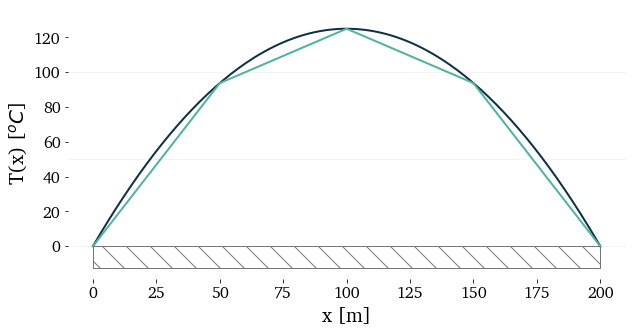

In [6]:
figure = plt.figure(figsize=(10, 5))
ax1 = figure.add_subplot(1,1,1)
plt.plot(x, T, color=line_color, linestyle='-', linewidth=2.0, zorder=1)
plt.plot(x_FDM, T_FDM, color=FDM_color, linestyle='-', linewidth=2.0, zorder=1)
plt.xlabel(r'x [m]', fontsize=fontsize_labels, **csfont)
plt.ylabel(r'T(x) [$^o C$]', fontsize=fontsize_labels, **csfont)
plt.xlim(-0.05*L, 1.05*L)
plt.ylim(-0.15*max(T), 1.1*max(T))
ax1.spines["top"].set_visible(False)
ax1.spines["bottom"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax1.spines["left"].set_visible(False)
ax1.margins(x=0)
plt.rcParams['axes.xmargin'] = 0

ax1.add_patch(
    patches.Rectangle(
        (0, -0.1*max(T)),
        L,
        0.1*max(T),
        Fill=False,
        edgecolor=bar_color,
        linewidth=1,
        hatch='\\'
    )
)

for label in (ax1.get_xticklabels()):
    label.set_fontname('Charter')
    label.set_fontweight('regular')
    label.set_fontsize(fontsize_axes)

for label in (ax1.get_yticklabels()):
    label.set_fontname('Charter')
    label.set_fontweight('regular')
    label.set_fontsize(fontsize_axes)

for y in np.arange(min(T), 1.1*max(T), 50):
    plt.plot([-0.05*L, 1.05*L], [y, y], "-", lw=1, color=help_lines, zorder=-1, alpha=0.4)

if save_plots==True: plt.savefig('../plots/example-heat-transfer-in-a-rod-FDM.png', dpi = 500, bbox_inches='tight')

***

### Finite Volume Method (FVM)